# HELIOS Seq Analysis of Hek cells
## What has been done so far...
Several DataProcessing steps were done till here with other software on the computational cluster
* fastq were trimmed and demultiplexed with cutadapt
* quality checked and further trimmed with trimmomatic
* reads were aligned with hisat2 to reference genome and reference spikeRNA, done for merged reads and not merged/paired reads separately
* count tables produced with featureCounts
* a custom python script extracts output from hisat2 for the spike RNAs and puts them in a table for further processing


In [1]:
# import required modules
import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from scipy.stats import ranksums

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#pd.set_option('display.max_columns', None)

## Generating the spike count tables
The data needs to be pivoted and shifted to allow clean concatenation.

In [2]:
# loading the alignment results of the spike ins, run scripts/hisat_extractor before that
spikes_merged = pd.read_csv("data/hisat2_spike_alignments_merged.csv")
spikes_merged["ratio"] = spikes_merged["aligned_reads"] / spikes_merged["reads_amount"]
spikes_merged

,sample,reads_amount,aligned_reads,alignment_rate,type,spike_RNA,ratio
0,bc03_Control,1339647,349895,26.12%,merged,biotinRna,0.261184
1,bc03_FK866,1271396,326445,25.68%,merged,biotinRna,0.256761
2,bc03_NRH,875658,212171,24.23%,merged,biotinRna,0.242299
3,bc03_Rotenone,73059,410,0.56%,merged,biotinRna,0.005612
4,bc04_Control,254827,204851,80.39%,merged,biotinRna,0.803883
...,...,...,...,...,...,...,...
331,bc07_Rotenone,883709,0,0.00%,merged,ppp149,0.000000
332,bc08_Control,144900,0,0.00%,merged,ppp149,0.000000
333,bc08_FK866,177374,0,0.00%,merged,ppp149,0.000000
334,bc08_NRH,104655,0,0.00%,merged,ppp149,0.000000


In [3]:
spikes_paired = pd.read_csv("data/hisat2_spike_alignments_paired.csv")
spikes_paired["ratio"] = spikes_paired["aligned_reads"] / spikes_paired["reads_amount"]
spikes_paired

,sample,reads_amount,aligned_reads,alignment_rate,type,spike_RNA,ratio
0,bc03_Control,6919295,2960557.0,42.79%,paired,biotinRna,0.427870
1,bc03_FK866,9373324,4418905.5,47.14%,paired,biotinRna,0.471434
2,bc03_NRH,8111244,2679596.0,33.04%,paired,biotinRna,0.330356
3,bc03_Rotenone,26110,3125.0,11.97%,paired,biotinRna,0.119686
4,bc04_Control,1924607,1743438.5,90.59%,paired,biotinRna,0.905867
...,...,...,...,...,...,...,...
331,bc07_Rotenone,8488512,0.0,0.00%,paired,ppp149,0.000000
332,bc08_Control,1152611,0.0,0.00%,paired,ppp149,0.000000
333,bc08_FK866,2245041,0.0,0.00%,paired,ppp149,0.000000
334,bc08_NRH,1154219,0.0,0.00%,paired,ppp149,0.000000


In [4]:
# check if order is the same and the index arrays are the same
(spikes_paired["sample"] == spikes_merged["sample"]).sum()/len(spikes_paired)

1.0

In [5]:
# combine the spike counts
spikes_combined = spikes_paired[["sample", "reads_amount", "aligned_reads", "spike_RNA"]].copy()
spikes_combined["reads_amount"] = spikes_paired["reads_amount"] + spikes_merged["reads_amount"]
spikes_combined["aligned_reads"] = spikes_paired["aligned_reads"] + spikes_merged["aligned_reads"]
spikes_combined["ratio"] = spikes_combined["aligned_reads"] / spikes_combined["reads_amount"]
spikes_combined.sort_values("sample")

,sample,reads_amount,aligned_reads,spike_RNA,ratio
0,bc03_Control,8258942,3310452.0,biotinRna,4.008325e-01
120,bc03_Control,8258942,629.0,nad351,7.615988e-05
168,bc03_Control,8258942,0.0,m7G122,0.000000e+00
96,bc03_Control,8258942,106463.0,nad200,1.289063e-02
192,bc03_Control,8258942,2.0,m7G250,2.421618e-07
...,...,...,...,...,...
71,bc08_Rotenone,2911770,550.0,nad60,1.888885e-04
47,bc08_Rotenone,2911770,557.0,nad36,1.912926e-04
23,bc08_Rotenone,2911770,2624499.0,biotinRna,9.013415e-01
311,bc08_Rotenone,2911770,0.0,ppp102,0.000000e+00


In [6]:
spikes_combined["barcode"] = [char[:4] for char in spikes_combined["sample"]]
pos_neg_dic = {
    "bc03": "positive",
    "bc04": "negative",
    "bc05": "positive",
    "bc06": "negative",
    "bc07": "positive",
    "bc08": "negative",
}
spike_dic = {
    "biotinRna": "biotin spikes",
    "m7G122": "m7G cap spikes",
    "m7G250": "m7G cap spikes",
    "m7G400": "m7G cap spikes",
    "nad102A": "NAD cap spikes",
    "nad200": "NAD cap spikes",
    "nad351": "NAD cap spikes",
    "nad36": "NAD cap spikes",
    "nad501": "NAD cap spikes",
    "nad60": "NAD cap spikes",
    "ppp102": "ppp cap spikes",
    "ppp149": "ppp cap spikes",
    "ppp301": "ppp cap spikes",
    "ppp51" : "ppp cap spikes"
}
lookup_dic = lambda x: pos_neg_dic[x]
lookup_spike = lambda x: spike_dic[x]
spikes_combined["pos_neg"] = spikes_combined["barcode"].apply(lookup_dic)
spikes_combined["spike_type"] = spikes_combined["spike_RNA"].apply(lookup_spike)
spikes_combined


,sample,reads_amount,aligned_reads,spike_RNA,ratio,barcode,pos_neg,spike_type
0,bc03_Control,8258942,3310452.0,biotinRna,0.400832,bc03,positive,biotin spikes
1,bc03_FK866,10644720,4745350.5,biotinRna,0.445794,bc03,positive,biotin spikes
2,bc03_NRH,8986902,2891767.0,biotinRna,0.321776,bc03,positive,biotin spikes
3,bc03_Rotenone,99169,3535.0,biotinRna,0.035646,bc03,positive,biotin spikes
4,bc04_Control,2179434,1948289.5,biotinRna,0.893943,bc04,negative,biotin spikes
...,...,...,...,...,...,...,...,...
331,bc07_Rotenone,9372221,0.0,ppp149,0.000000,bc07,positive,ppp cap spikes
332,bc08_Control,1297511,0.0,ppp149,0.000000,bc08,negative,ppp cap spikes
333,bc08_FK866,2422415,0.0,ppp149,0.000000,bc08,negative,ppp cap spikes
334,bc08_NRH,1258874,0.0,ppp149,0.000000,bc08,negative,ppp cap spikes


In [7]:
def pivot_spike_alignments(df):
    """creates a read-Count table from the spikeRNA DataFrame in 
    similar shape than featureCounts for later concatenation """
    df_pivoted = df.pivot(columns="sample", index = "spike_RNA", values = "aligned_reads")
    df_pivoted.reset_index(inplace = True)
    df_pivoted.rename(columns={"spike_RNA": "Feature"}, inplace=True)
    return df_pivoted

spikes_pivot = pivot_spike_alignments(spikes_combined)
spikes_table = spikes_pivot.set_index("Feature").T
spikes_table.head()

Feature,biotinRna,m7G122,m7G250,m7G400,nad102A,nad200,nad351,nad36,nad501,nad60,ppp102,ppp149,ppp301,ppp51
sample,,,,,,,,,,,,,,
bc03_Control,3310452.0,0.0,2.0,0.0,51130.0,106463.0,629.0,419814.0,5316.0,3649255.0,0.0,0.0,34.5,16.0
bc03_FK866,4745350.5,0.0,10.0,6.0,50255.5,63939.5,355.0,214832.0,2175.5,4564318.0,0.0,0.0,6.0,1.0
bc03_NRH,2891767.0,0.0,2.5,0.0,37667.0,69139.5,126.0,205189.5,2278.5,5194490.5,0.0,0.0,4.0,1.5
bc03_Rotenone,3535.0,0.0,0.0,0.0,27.0,33.0,0.0,172.0,1.0,2344.5,0.0,0.0,0.0,0.0
bc04_Control,1948289.5,0.0,0.0,0.0,160.5,46.5,0.0,2473.5,0.5,2399.5,0.0,0.0,0.0,0.0


## Concatenation of featureCountsTable and the spikes

In [8]:
# import the featureCounts tables
counts_table_paired = pd.read_csv("data/feature_counts_paired.txt", skiprows = 1, delimiter = "\t")
counts_table_merged = pd.read_csv("data/feature_counts_single.txt", skiprows = 1, delimiter = "\t")

def clean_columns_featureCounts(df):
    """cleans up the column-names of the feature count tables, 
    which are leftover of the absolute paths supplied in shell"""
    new_cols = []
    for col in df.columns:
        col = col.replace("/pfs/work7/workspace/scratch/hd_kg304-YZ619/04_aligned_sequences/e_1/", "")
        col = col.replace(".paired.sorted.bam", "")
        col = col.replace(".short.sorted.bam", "")
        col = col.replace("merged_trimmed_", "")
        new_cols.append(col)
    new_cols[0] = "Feature"
    df.columns = new_cols    
    return df

counts_table_paired = clean_columns_featureCounts(counts_table_paired)
counts_table_merged = clean_columns_featureCounts(counts_table_merged)


counts_table_paired.head()
counts_table_merged.head()

,Feature,Chr,Start,End,Strand,Length,bc03_Control,bc03_FK866,bc03_NRH,bc03_Rotenone,...,bc06_NRH,bc06_Rotenone,bc07_Control,bc07_FK866,bc07_NRH,bc07_Rotenone,bc08_Control,bc08_FK866,bc08_NRH,bc08_Rotenone
0,ENSG00000290825.1,chr1;chr1;chr1,11869;12613;13221,12227;12721;14409,+;+;+,1657,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000223972.6,chr1;chr1;chr1;chr1;chr1;chr1,12010;12179;12613;12975;13221;13453,12057;12227;12697;13052;13374;13670,+;+;+;+;+;+,632,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000278267.1,chr1,17369,17436,-,68,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000243485.5,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31109;31097,+;+;+;+;+,1021,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Building the Annotation Framework
Now that the main counttable is accomplished, i was looking for a way to add more data. I chose to build an anndata object which originates from single cell analysis. Even though this is bulk data, i think this framework is useful for data annotation.  
The general idea is to have a central numpy array as a datamatrix (**.X**) and two dataframes annotating the variables (**.var**) and the observations (**.obs**). Here i define each barcode as one observation and each gene as one variable. Additionally anndata features the option to store dataframes of the same shape in different **layers**. So later i will add a biotin normalized layer. Corresponding data where shape matches only in one direction can be added to **.obsm** and **.varm**, which is used for the spikes here and later for the DE-genes calculation.

In [9]:
# extract the count data
value_columns = counts_table_paired.columns[counts_table_paired.columns.str.startswith("bc")]
raw_counts_paired = counts_table_paired[value_columns].values
raw_counts_merged = counts_table_merged[value_columns].values

raw_counts = raw_counts_paired + raw_counts_merged

# initialize anndata object, transpose to have samples in obs and genes in var
adata = ad.AnnData(raw_counts.T, dtype=np.int32)
display(adata)
# annotate the genes
genes_columns = counts_table_paired.columns[~counts_table_paired.columns.str.startswith("bc")]
adata.var = counts_table_paired[genes_columns].copy()

# annotate the barcodes
adata.obs = pd.DataFrame({"sample":value_columns})

# set the indeces
adata.obs.set_index("sample", inplace = True)
adata.var.set_index("Feature", inplace = True)

# add the spikes to obsm
adata.uns["spike_counts"] = spikes_table
adata.uns["original_spike_table"] = spikes_combined

# check if all information
adata

AnnData object with n_obs × n_vars = 24 × 70116

AnnData object with n_obs × n_vars = 24 × 70116
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'
    uns: 'spike_counts', 'original_spike_table'

## Annotation of the observations


In [10]:
# adding encoding for easier subsetting
adata.obs["encoding"] = [char[:4] for char in adata.obs.index]
adata.obs["pos_neg"] = adata.obs["encoding"].apply(lookup_dic)
adata.obs["treatment"] = [char[5:] for char in adata.obs.index]

# counting the reads for each sample
adata.obs["gene_counts"] = adata.X.sum(1)
adata.obs

,encoding,pos_neg,treatment,gene_counts
sample,,,,
bc03_Control,bc03,positive,Control,31453
bc03_FK866,bc03,positive,FK866,84047
bc03_NRH,bc03,positive,NRH,25701
bc03_Rotenone,bc03,positive,Rotenone,27239
bc04_Control,bc04,negative,Control,762
bc04_FK866,bc04,negative,FK866,1647
bc04_NRH,bc04,negative,NRH,608
bc04_Rotenone,bc04,negative,Rotenone,755
bc05_Control,bc05,positive,Control,29990


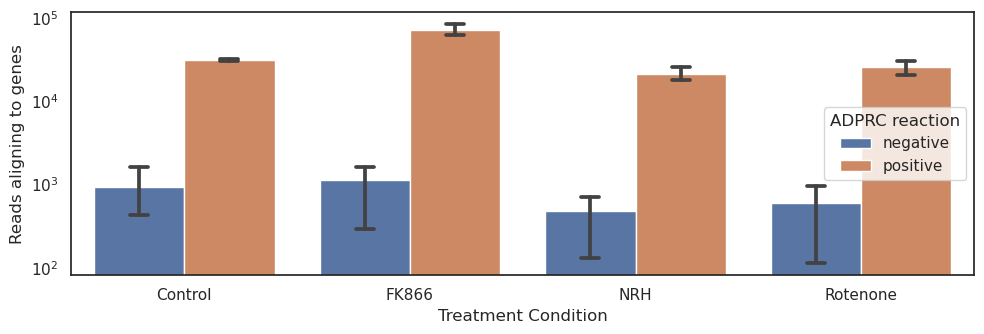

In [32]:
# visualization of gene counts
fig, ax = plt.subplots()
sns.barplot(adata.obs, x = "treatment", y = "gene_counts", hue = "pos_neg", capsize = .08, linewidth = 1, log = True)
plt.legend(title = "ADPRC reaction")
plt.xlabel("Treatment Condition")
plt.ylabel("Reads aligning to genes")
plt.tight_layout()
plt.savefig("figures/readnumbers_treatment.png", dpi=300, pad_inches=0)

## Spike and gene read count Analysis

In [12]:
spikes_combined

,sample,reads_amount,aligned_reads,spike_RNA,ratio,barcode,pos_neg,spike_type
0,bc03_Control,8258942,3310452.0,biotinRna,0.400832,bc03,positive,biotin spikes
1,bc03_FK866,10644720,4745350.5,biotinRna,0.445794,bc03,positive,biotin spikes
2,bc03_NRH,8986902,2891767.0,biotinRna,0.321776,bc03,positive,biotin spikes
3,bc03_Rotenone,99169,3535.0,biotinRna,0.035646,bc03,positive,biotin spikes
4,bc04_Control,2179434,1948289.5,biotinRna,0.893943,bc04,negative,biotin spikes
...,...,...,...,...,...,...,...,...
331,bc07_Rotenone,9372221,0.0,ppp149,0.000000,bc07,positive,ppp cap spikes
332,bc08_Control,1297511,0.0,ppp149,0.000000,bc08,negative,ppp cap spikes
333,bc08_FK866,2422415,0.0,ppp149,0.000000,bc08,negative,ppp cap spikes
334,bc08_NRH,1258874,0.0,ppp149,0.000000,bc08,negative,ppp cap spikes


In [13]:
# adding the total amount of reads for pos and neg
total_pos_reads = spikes_combined[spikes_combined["pos_neg"] == "positive"]\
    .groupby(["pos_neg","sample"])["reads_amount"].unique().sum()[0]
total_neg_reads = spikes_combined[spikes_combined["pos_neg"] == "negative"]\
    .groupby(["pos_neg","sample"])["reads_amount"].unique().sum()[0]
totals = np.array([total_neg_reads, total_pos_reads])
totals


array([29835341, 77000930])

In [14]:
spike_plot_df = spikes_combined.groupby(["pos_neg", "spike_type"])["aligned_reads"].sum().reset_index()
junk = totals - spike_plot_df.groupby("pos_neg")["aligned_reads"].sum()

spike_plot_df.groupby("pos_neg")["aligned_reads"].sum()

pos_neg
negative    26869198.5
positive    70349359.0
Name: aligned_reads, dtype: float64

In [15]:
genomic_reads = adata.obs.groupby("pos_neg")["gene_counts"].sum()
genomic_reads_df = pd.DataFrame({"pos_neg": ["negative", "positive"], "spike_type":["endogenous RNA", "endogenous RNA"], 
                               "aligned_reads": [genomic_reads[0], genomic_reads[1]]})
junk_df = pd.DataFrame({"pos_neg": ["negative", "positive"], "spike_type":["junk", "junk"], 
                               "aligned_reads": [junk[0], junk[1]]})

In [16]:
spike_plot_df = pd.concat([spike_plot_df, genomic_reads_df, junk_df]).sort_values(["pos_neg", "aligned_reads"], ascending = False)
pivot = spike_plot_df.pivot(values="aligned_reads", index = "pos_neg", columns = "spike_type")
pivot

spike_type,NAD cap spikes,biotin spikes,endogenous RNA,junk,m7G cap spikes,ppp cap spikes
pos_neg,,,,,,
negative,14196.5,26854755.0,9548.0,2966142.5,9.5,237.5
positive,32401268.5,37947723.0,450421.0,6651571.0,55.5,312.0


In [17]:
# proportion of endogenous RNA
spike_plot_df.query("spike_type == 'endogenous RNA'")["aligned_reads"].sum()/spike_plot_df["aligned_reads"].sum()


0.004286906978287403

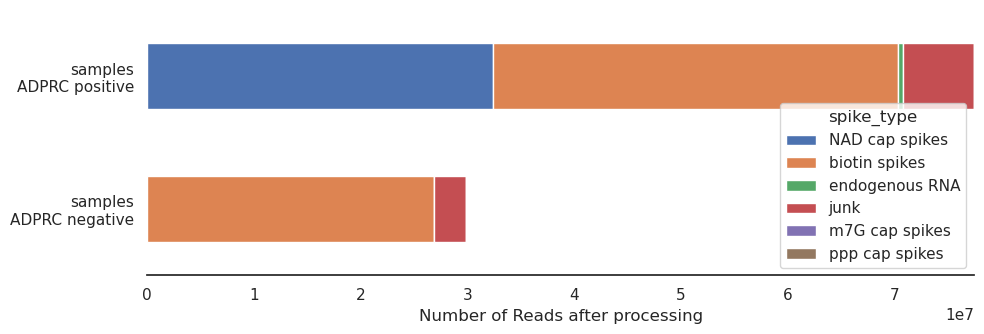

In [31]:
import seaborn as sns
sns.set_theme(style="white")
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True
pivot.plot(kind = "barh", stacked = True, ax = ax)
ax.set_yticklabels(["samples\nADPRC negative", "samples\nADPRC positive"])
ax.set(ylabel=None, xlabel="Number of Reads after processing")
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
sns.move_legend(ax, "lower right")
plt.tight_layout()
plt.savefig("figures/spike_content.png", dpi=300, pad_inches=0)

## Annotation of the genes with biomaRt

In [19]:
# remove ends of Ensembl ID to facilitate query
cut_end = lambda x: x.split(".")[0]
ids = pd.Series(adata.var.index).apply(cut_end)
adata.var["Ensemble_ID"] = list(ids)

# export to a file for import in R
adata.var[["Ensemble_ID"]].to_csv("tmp/query_list.csv", index = False)

In [20]:
# call the R function if the query-result doesn't exist, note this is bash syntax
# R needs to be avaiable in PATH and the library biomaRt to be installed
# call function from terminal to be sure and check if it worked

! if [ -e "tmp/mart_query_afterR.csv" ]; then echo "The query already exists."; else Rscript scripts/query_biomart.R tmp/query_list.csv tmp/mart_query_afterR.csv; fi

The query already exists.


In [21]:
# now get the query data
Mart_query = pd.read_csv("tmp/mart_query_afterR.csv")
# problem arises from non multiple entrezIds for the same ensembl_id
display(Mart_query.query("ensembl_gene_id == 'ENSG00000275748'").head(3))
# solution: dropping the dupes and only keep the first occurence
Mart_query.drop_duplicates(subset="ensembl_gene_id", keep="first", inplace = True)
# check if multiassingments are left:
Mart_query.value_counts("ensembl_gene_id").head()


,ensembl_gene_id,external_gene_name,description,gene_biotype,entrezgene_id,start_position,end_position,chromosome_name
73072,ENSG00000275748,ARL17B,ADP ribosylation factor like GTPase 17B [Sourc...,protein_coding,51326.0,389590,511415,HSCHR17_1_CTG5
73073,ENSG00000275748,ARL17B,ADP ribosylation factor like GTPase 17B [Sourc...,protein_coding,100506084.0,389590,511415,HSCHR17_1_CTG5
73074,ENSG00000275748,ARL17B,ADP ribosylation factor like GTPase 17B [Sourc...,protein_coding,100996709.0,389590,511415,HSCHR17_1_CTG5


ensembl_gene_id
ENSG00000000003    1
ENSG00000259289    1
ENSG00000259296    1
ENSG00000259295    1
ENSG00000259294    1
dtype: int64

In [22]:
print("Shape of adata.var before merge: {}".format(adata.var.shape))
print("Shape of the Mart_query before merge: {}".format(Mart_query.shape))
temp_df = adata.var.merge(Mart_query, how = "left", left_on = "Ensemble_ID", right_on = "ensembl_gene_id")
temp_df.index = adata.var_names
adata.var = temp_df
print("Shape of adata.var after merging the Mart_query: {}".format(adata.var.shape))

Shape of adata.var before merge: (70116, 6)
Shape of the Mart_query before merge: (70116, 8)
Shape of adata.var after merging the Mart_query: (70116, 14)


In [23]:
#check if gene annotation is avaiable: 
adata.var.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID',
       'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype',
       'entrezgene_id', 'start_position', 'end_position', 'chromosome_name'],
      dtype='object')

## Correlation of the spikes
To be able to normalize with biotinRNA a correlation of nad spikes with the biotinRNA is required.

In [24]:
adata.uns["spike_correlation"] = adata.uns["spike_counts"].corr(method = "pearson", min_periods = 2)
adata.uns["spike_correlation"]

Feature,biotinRna,m7G122,m7G250,m7G400,nad102A,nad200,nad351,nad36,nad501,nad60,ppp102,ppp149,ppp301,ppp51
Feature,,,,,,,,,,,,,,
biotinRna,1.000000,NaN,0.391362,0.552358,0.512880,0.388128,0.605112,0.357407,0.375910,0.431581,NaN,NaN,0.360814,0.306449
m7G122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m7G250,0.391362,NaN,1.000000,0.472261,0.478037,0.289344,0.299546,0.263198,0.232271,0.597469,NaN,NaN,-0.032567,0.150388
m7G400,0.552358,NaN,0.472261,1.000000,0.421183,0.345851,0.390165,0.244710,0.169987,0.364916,NaN,NaN,0.174911,0.228565
nad102A,0.512880,NaN,0.478037,0.421183,1.000000,0.914740,0.852566,0.909307,0.884745,0.856896,NaN,NaN,-0.051766,0.417995
nad200,0.388128,NaN,0.289344,0.345851,0.914740,1.000000,0.829486,0.985226,0.911450,0.803367,NaN,NaN,-0.012002,0.406130
nad351,0.605112,NaN,0.299546,0.390165,0.852566,0.829486,1.000000,0.843727,0.871996,0.684041,NaN,NaN,0.239209,0.461333
nad36,0.357407,NaN,0.263198,0.244710,0.909307,0.985226,0.843727,1.000000,0.948569,0.757766,NaN,NaN,-0.031451,0.421996
nad501,0.375910,NaN,0.232271,0.169987,0.884745,0.911450,0.871996,0.948569,1.000000,0.700049,NaN,NaN,0.029411,0.467091


## Biotin Normalization

In [25]:
# 1 is added to each feature for later DE calculation, needs to be done now to be considerd during normalization
adata.layers["biotin_scaled"] = adata.X + 1

# extracting biotin_counts
adata.obs["biotinRna"] = adata.uns["spike_counts"].loc[:,"biotinRna"]
adata.obs["biotin_scalingF"] = adata.obs["biotinRna"]/adata.obs["biotinRna"].sum()

# scale by biotin counts, for vector calculation shape in one direction needs to be 1
scaling_vector = np.array(adata.obs["biotin_scalingF"]).reshape(len(adata.obs["biotin_scalingF"]),1)
adata.layers["biotin_scaled"]=(adata.X + 1) / scaling_vector

# check effect of scaling 
number = 2
print("scaled:\n",adata.layers["biotin_scaled"][:,number].T.round(2))
print("unscaled:\n",adata.X[:,number].T)

scaled:
 [1.958000e+01 4.097000e+01 2.241000e+01 1.833168e+04 3.326000e+01
 2.143000e+01 4.153000e+01 2.387711e+04 2.109000e+01 1.545000e+01
 3.387000e+01 1.556000e+01 2.125000e+01 1.773000e+01 2.691000e+01
 1.560000e+01 3.237000e+01 1.570000e+01 3.964000e+01 1.101000e+01
 5.748000e+01 2.979000e+01 5.751000e+01 2.469000e+01]
unscaled:
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
# also generate a normalized spike counts table
adata.uns["normalized_spike_counts"] = (adata.uns["spike_counts"] + 1) / scaling_vector
adata.uns["normalized_spike_counts"].head()



Feature,biotinRna,m7G122,m7G250,m7G400,nad102A,nad200,nad351,nad36,nad501,nad60,ppp102,ppp149,ppp301,ppp51
sample,,,,,,,,,,,,,,
bc03_Control,6.480250e+07,19.575115,58.725344,19.575115,1.000895e+06,2.084045e+06,12332.322335,8.217927e+06,104080.885488,7.143461e+07,19.575115,19.575115,694.916576,332.776952
bc03_FK866,6.480249e+07,13.655994,150.215934,95.591958,6.863025e+05,8.731711e+05,4861.533867,2.933758e+06,29722.270961,6.233031e+07,13.655994,13.655994,95.591958,27.311988
bc03_NRH,6.480250e+07,22.409301,78.432555,22.409301,8.441136e+05,1.549390e+06,2845.981265,4.598176e+06,51082.002319,1.164049e+08,22.409301,22.409301,112.046507,56.023253
bc03_Rotenone,6.482081e+07,18331.676945,18331.676945,18331.676945,5.132870e+05,6.232770e+05,18331.676945,3.171380e+06,36663.353890,4.299695e+07,18331.676945,18331.676945,18331.676945,18331.676945
bc04_Control,6.480251e+07,33.261216,33.261216,33.261216,5.371686e+03,1.579908e+03,33.261216,8.230488e+04,49.891824,7.984355e+04,33.261216,33.261216,33.261216,33.261216


In [27]:
# export the scaled reads to a csv for processing in edgeR
df1 = pd.DataFrame(adata.layers["biotin_scaled"].T, index = adata.var_names, columns = adata.obs_names)
df2 = adata.uns["normalized_spike_counts"].T
pd.concat([df1,df2]).to_csv("tmp/norm_counts.csv")

## Filtering
To reduce dimensionality and increase quality the variables with almost no counts are removed.

In [28]:
# save the raw counts before filtering
adata.raw = adata

# filtering 
min_total_counts = 10
min_count_maximum_for_sample = 3

# values to filter
adata.var["total_values"] = adata.X.sum(0)
adata.var["highest_sample"] = adata.X.max(0)

# actual filtering
genes_before_filtering = adata.var.shape[0]
adata = adata[:, np.logical_and(adata.var["total_values"]>=min_total_counts, 
                                        adata.var["highest_sample"] >= min_count_maximum_for_sample)].copy()
genes_after_filtering = adata.var.shape[0]
print("{} genes were filtered due to low read count. {} genes are remaining."\
      .format(genes_before_filtering-genes_after_filtering, genes_after_filtering))

64528 genes were filtered due to low read count. 5588 genes are remaining.


In [29]:
# check if all annotations are there
adata

AnnData object with n_obs × n_vars = 24 × 5588
    obs: 'encoding', 'pos_neg', 'treatment', 'gene_counts', 'biotinRna', 'biotin_scalingF'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID', 'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype', 'entrezgene_id', 'start_position', 'end_position', 'chromosome_name', 'total_values', 'highest_sample'
    uns: 'spike_counts', 'original_spike_table', 'spike_correlation', 'normalized_spike_counts'
    layers: 'biotin_scaled'

In [30]:
# save the data for subsequent analysis
adata.write("data/anndata.h5ad")
